In [2]:
from fcn_roi_align_opt.baseline_model.vgg import VGGNet
from fcn_roi_align_opt.baseline_model.fcn8s import FCN8s
import skimage
from distutils.version import LooseVersion
import numpy as np
from skimage.transform import resize as sk_resize
import matplotlib.pyplot as plt
import torch
import os
from torchvision.ops import RoIAlign
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
def resize(image, output_shape, order=1, mode='constant', cval=0, clip=True,
           preserve_range=False, anti_aliasing=False, anti_aliasing_sigma=None):
    """A wrapper for Scikit-Image resize().
    Scikit-Image generates warnings on every call to resize() if it doesn't
    receive the right parameters. The right parameters depend on the version
    of skimage. This solves the problem by using different parameters per
    version. And it provides a central place to control resizing defaults.
    """
    if LooseVersion(skimage.__version__) >= LooseVersion("0.14"):
        # New in 0.14: anti_aliasing. Default it to False for backward
        # compatibility with skimage 0.13.
        return skimage.transform.resize(
            image, output_shape,
            order=order, mode=mode, cval=cval, clip=clip,
            preserve_range=preserve_range, anti_aliasing=anti_aliasing,
            anti_aliasing_sigma=anti_aliasing_sigma)
    else:
        return skimage.transform.resize(
            image, output_shape,
            order=order, mode=mode, cval=cval, clip=clip,
            preserve_range=preserve_range)
    
    
def unmold_mask(mask, bbox, image_shape):
    """Converts a mask generated by the neural network to a format similar
    to its original shape.
    mask: [height, width] of type float. A small, typically 28x28 mask.
    bbox: [y1, x1, y2, x2]. The box to fit the mask in.
    Returns a binary mask with the same size as the original image.
    """
    threshold = 0.5
    y1, x1, y2, x2 = bbox
    mask = resize(mask, (y2 - y1, x2 - x1))
    mask = np.where(mask >= threshold, 1, 0).astype(np.bool)

    # Put the mask in the right location.
    full_mask = np.zeros(image_shape, dtype=np.bool)
    full_mask[y1:y2, x1:x2] = mask
    return full_mask


import math
image_shape = (224, 224)
from pathlib import Path
import nibabel as nib

num_slices = 153
ROOT_DIR = Path.cwd()

def read_nib(path):
    'read from the path'
    img = nib.load(str(path))
    data = img.get_fdata()
    return np.array(data)

def read_single_scan(scan_slice, train = True):
    'read the first 4 CT scan slices and 1 mask'
    scan_idx, slice_idx = scan_slice
    scan_dir = ROOT_DIR / 'data' / ('train' if train else 'val') / str(scan_idx)
    scan_data = []
    paths = sorted([x for x in scan_dir.iterdir()])
    for path in paths:
        if path.is_dir():
            scan_type = path / (path.name + '.nii')
            slice = read_nib(scan_type)[:, :, slice_idx]
            scan_data.append(slice)

    return np.stack(scan_data, axis=-1)

idx = 91
sample_to_path = lambda x: (math.floor(x / num_slices) + 1, x % num_slices)
sample = read_single_scan(sample_to_path(idx))

In [4]:
mask = skimage.transform.resize(sample[:, :, -1], (224, 224))
img224 = mask.astype(np.float32)
img28 = sk_resize(img224, (28, 28)).astype(np.float32)

In [5]:
def show_single_img(image, label):
    """Show image"""
    cmap = 'gray'
    if label:
        cmap = 'binary'
    plt.imshow(image, cmap = cmap)
    plt.show()


def dice_loss(input, target):
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()

    return 1 - ((2. * intersection + smooth) /
                (iflat.sum() + tflat.sum() + smooth))


Resampled mask 224 from 28

Image 224

In [6]:
roi_align = RoIAlign((28,28), spatial_scale = 1.0, sampling_ratio= 2)
roi_align_backwards = RoIAlign((224, 224), spatial_scale=1.0, sampling_ratio=2)

In [7]:
rois_np = np.zeros((32, 5))
for i in range(len(rois_np)):
    rois_np[i] = [i, 0, 0, 233, 233]
rois = rois_np.astype(np.float32)
rois = torch.from_numpy(rois)

In [8]:
images = torch.from_numpy(img224)
images = torch.unsqueeze(images, dim=0)
images = images.repeat(32,1,1,1)

In [9]:
aligned_img = roi_align(images, rois)

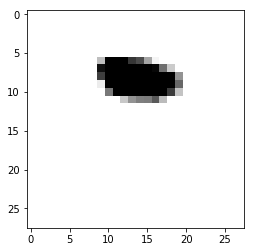

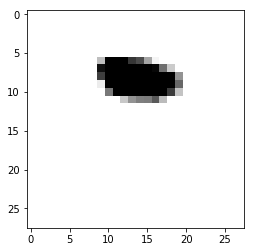

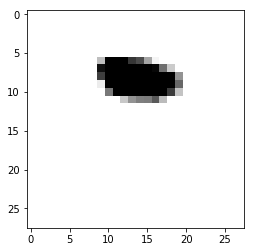

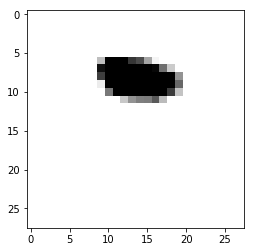

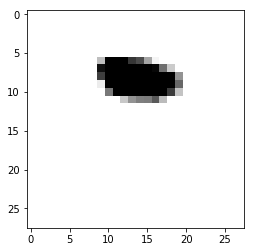

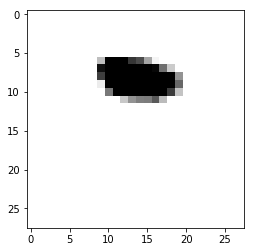

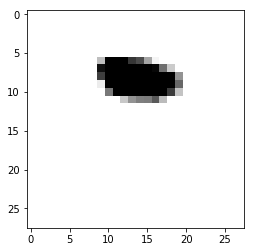

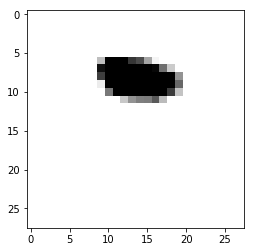

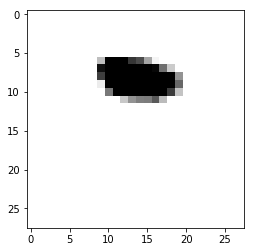

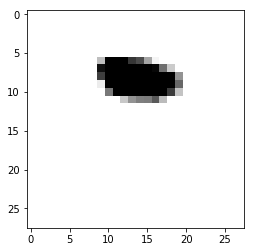

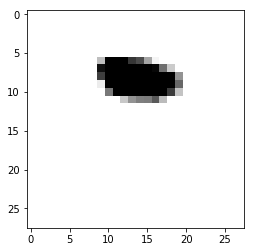

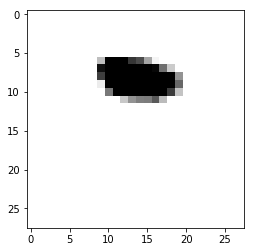

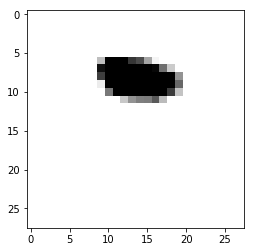

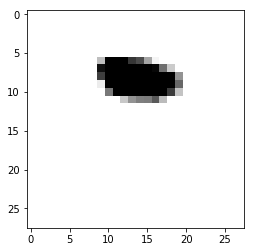

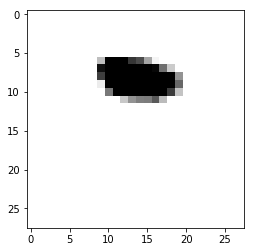

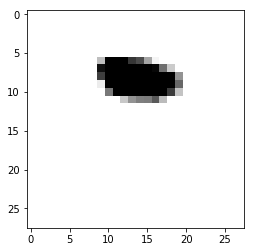

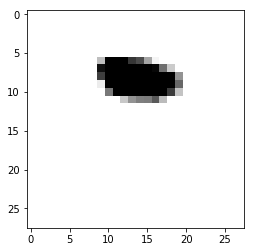

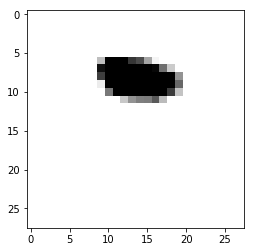

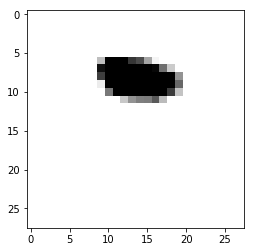

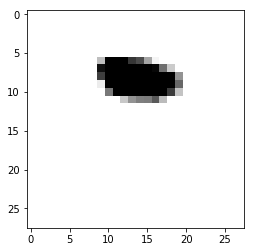

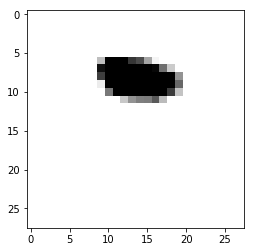

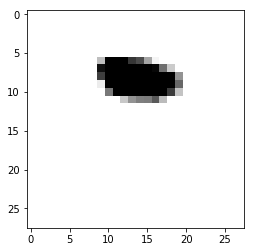

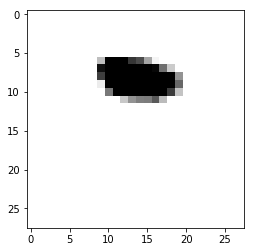

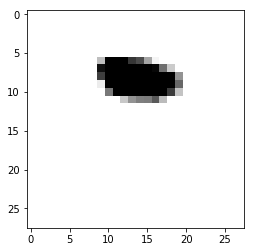

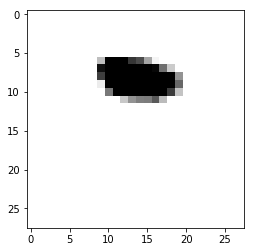

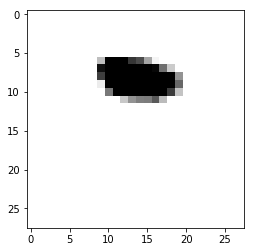

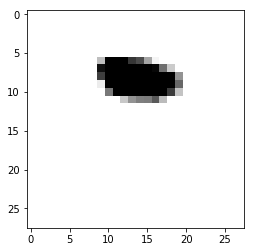

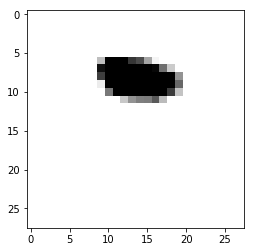

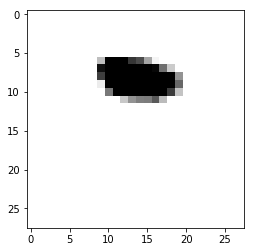

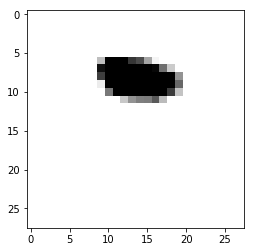

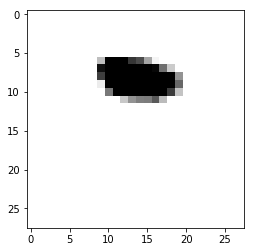

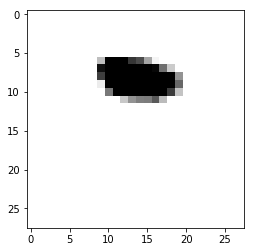

In [10]:
for img in range(32):
    show_single_img(aligned_img[img][0], label=True)
# make it back to 224 size

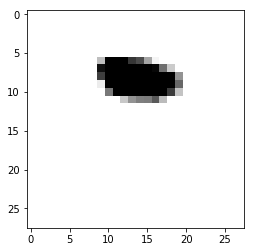

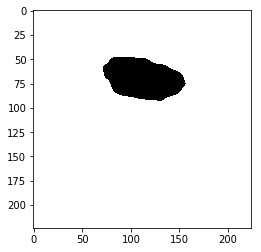

In [11]:
aligned_img = roi_align(images, rois)[0][0]
show_single_img(aligned_img, label=True)
resampled_mask_from_roi_align = unmold_mask(aligned_img, [0, 0, 223, 223], img224.shape)
show_single_img(resampled_mask_from_roi_align, label=True)

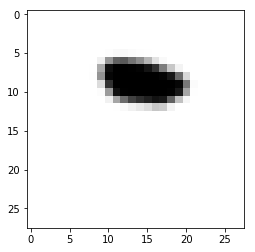

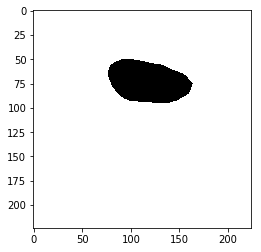

In [12]:
show_single_img(img28, label=True)
resampled_mask = unmold_mask(img28, [0, 0, 223, 223], img224.shape)
show_single_img(resampled_mask, label=True)

In [13]:
dice_loss(input= aligned_img, target= torch.from_numpy(img28))

tensor(0.1614)

In [14]:
from pathlib import Path
import torch.nn as nn
import torch
x = torch.rand(5, 4096, 7,7)
m = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)(x)

In [15]:
dice_loss(input= torch.from_numpy(resampled_mask), target=torch.from_numpy(img224))

tensor(0.0323)

In [16]:
resampled_mask.shape

(224, 224)

In [17]:
img224.shape

(224, 224)

In [18]:
images.shape

torch.Size([32, 1, 224, 224])

In [19]:
np.sum(resampled_mask == resampled_mask_from_roi_align) / len(resampled_mask.reshape(-1))

0.9868263711734694

In [45]:

import matplotlib.pyplot as plt
import numpy as np

def plot(y):
    x = np.arange(0,1, 0.0001)
    plt.xlim(0, 1)
    plt.plot(x, list(map(y, x)))

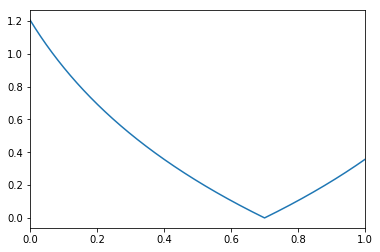

In [47]:
y = lambda x: -np.log(1-np.abs(0.7-x))
plot(y)

In [48]:
def minimize_mask(bbox, mask, mini_shape):
    """Resize masks to a smaller version to reduce memory load.
    Mini-masks can be resized back to image scale using expand_masks()
    See inspect_data.ipynb notebook for more details.
    """
    mini_mask = np.zeros(mini_shape + (mask.shape[-1],), dtype=bool)
    for i in range(mask.shape[-1]):
        # Pick slice and cast to bool in case load_mask() returned wrong dtype
        m = mask[:, :, i].astype(bool)
        y1, x1, y2, x2 = bbox[i][:4]
        m = m[y1:y2, x1:x2]
        if m.size == 0:
            raise Exception("Invalid bounding box with area of zero")
        # Resize with bilinear interpolation
        m = resize(m, mini_shape)
        mini_mask[:, :, i] = np.around(m).astype(np.bool)
    return mini_mask

def expand_mask(bbox, mini_mask, image_shape):
    """Resizes mini masks back to image size. Reverses the change
    of minimize_mask().
    See inspect_data.ipynb notebook for more details.
    """
    mask = np.zeros(image_shape[:2] + (mini_mask.shape[-1],), dtype=bool)
    for i in range(mask.shape[-1]):
        m = mini_mask[:, :, i]
        y1, x1, y2, x2 = bbox[i][:4]
        h = y2 - y1
        w = x2 - x1
        # Resize with bilinear interpolation
        m = resize(m, (h, w))
        mask[y1:y2, x1:x2, i] = np.around(m).astype(np.bool)
    return mask


In [55]:
mask = img224[..., np.newaxis]
mini_mask = minimize_mask([[0,0,223,223]], mask, (28,28))

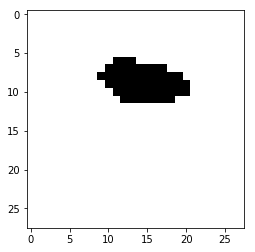

In [58]:
show_single_img(mini_mask[:, :, 0], label=True)


In [59]:
exp_mask = expand_mask([[0,0,223,223]], mini_mask, (224, 224))

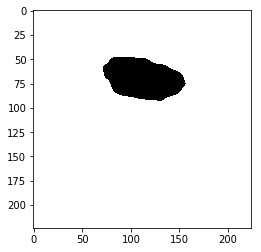

In [72]:
show_single_img(resampled_mask_from_roi_align, label=True)

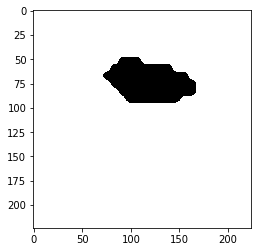

In [61]:
show_single_img(exp_mask[:, :, 0], label=True)

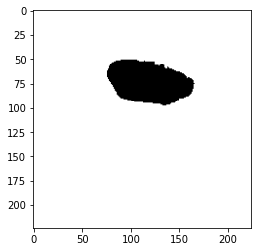

In [62]:
show_single_img(img224, label=True)

In [68]:
np.sum(img224 == exp_mask[:, :, 0])/len(img224.reshape(-1))*100

98.91183035714286

In [73]:
# dice loss of img224 and expanded mask
dice_loss(input=torch.from_numpy(img224), target=torch.from_numpy(exp_mask[:, :, 0]))

tensor(0.0628)

In [74]:
# dice loss of img224 adn resampled from roi align
dice_loss(input=torch.from_numpy(img224), target=torch.from_numpy(resampled_mask_from_roi_align))

tensor(0.1304)